# 0. Imports

In [ ]:
import numpy as np 

from collections import defaultdict 
from tqdm import tqdm

import time
import matplotlib.pyplot as plt
import random

# 1. Gridworld

In [ ]:
class GridWorld:
    """
    A GridWorld consists of an mxn sized world and the agent-position within this grid.
    The agent can typically choose between four actions: [LEFT, TOP, RIGHT, DOWN].
    Additionally, there is typically a goal - a specific tile, which the agent is supposed to reach.
    When the agent reaches this tile, a reward is given and the environment is reset.
    """

    def __init__(self, width, height, start, goal, walls, traps):
        """
        Create a Grid World

        Args:
            width (int): The width of the grid world
            height (int): The height of the grid world
            start (tuple): The start point for an agent
            goal (tuple): The goal point for an agent
            walls (list): The walls in the world which an agent can not pass
            traps (list): The traps in the world on which an agent get penalized
        """

        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.walls = walls
        self.traps = traps

    def get_state_space(self):
        """
        Returns:
            list: All states in the grid world
        """

        return [(x, y) for x in range(self.width) for y in range(self.height)]

    def get_reachable_states(self, state):
        """
        Get reachable states from a given state.

        Args:
            state (tuple): The current state

        Returns:
            dict: A dictionary mapping next states to the actions needed to get there
        """
        next_states = defaultdict(str)

        for action in self.get_action_space():
            next_states[self.transition(state, action)] = action

        next_states.pop(state, None)

        return next_states

    def get_action_space(self):
        """
        Returns:
            list: All actions which can be performed in the grid world
        """

        return [0, 1, 2, 3]

    def transition(self, state, action):
        """
        After an action is performed the new position of the agent is returned.
        A move cannot be performed on a wall, so if an action would lead to an agent to end up on a wall,
        the agent will stay in its position.

        Args:
            state (tuple): The agent's current state
            action (str): The agent's action

        Returns:
            tuple: New state coordinates
        """

        x, y = state

        if action == 0: #Left
            x = max(0, x - 1)
        elif action == 2: #Up
            y = max(0, y - 1)
        elif action == 1: #Right
            x = min(self.width - 1, x + 1)
        elif action == 3: #Down
            y = min(self.height - 1, y + 1)

        # Keep the current state if the action would end up on a wall
        if (x, y) in self.walls:
            return state
        else:
            return (x, y)

    def reward(self, next_state):
        """Computes the reward for a state. The Reward for an empty file = -0.025, for a trap or wall = -1, and the goal = 1

        Args:
            next_state (tuple): The next state on which the agent is about to step

        Returns:
            float: the reward of a state
        """

        if next_state in self.traps:
            return -1

        elif next_state == self.goal:
            return 1

        elif next_state in self.walls:
            return -1

        else:
            # for an empty field
            return -0.25

In [ ]:
class SimpleAgent:
    """
    A custom agent (i.e. a policy) to interact with the GridWorld environment.
    The agent follows an epsilon-greedy strategy, which means that with probability
    (1 - epsilon) the agent selects the best action according to the policy, and with
    probability epsilon, it selects a random action.

    Attributes:
        grid_world (GridWorld): The GridWorld environment.
        epsilon (float): The exploration rate for the epsilon-greedy strategy. Default is 0.1.
    """

    def __init__(self, grid_world, epsilon=0.1):
        self.grid_world = grid_world
        self.epsilon = epsilon


    def get_action(self, Q_values, state):
        """
        Get the action to be performed in the current state, following an
        epsilon-greedy strategy.

        Args:
            state (tuple): The current state.

        Returns:
            str: The action to be performed.
        """

        actions = self.grid_world.get_action_space()

        if random.random() < self.epsilon:
          return random.choice(actions)
        else:
          values = []

          #get_action_space
          for i in range(4):

            values.append(Q_values[state, i])

        return np.argmax(values)

In [ ]:
def init_Q_values(world):
  """
  Creates randomly initalized Q-values. The keys are a tuple of the state description and an action from the action space.
  The keys are in the form ((x,y),a).

   Args:
            world (GridWorld): The world to define the state space and action space.

  Returns:
            dict: The unoptimzed Q-values
  """
  Q_values = {}

  for state in world.get_state_space():
    for action in world.get_action_space():

      if state in world.walls:
        Q_values[(state, action)] = 0

      elif state == world.goal:
        Q_values[(state,action)] = 1
         
      #initialize Q_values for all other states arbitrarily
      else:
        Q_values[(state,action)] = random.random()

  return Q_values

In [ ]:
def run_episode(agent, grid_world, Q_values):
    """
    Run a single episode with the given agent and environment until the goal state is reached.

    Args:
        agent (SimpleAgent): The agent following a certain policy.
        grid_world (GridWorld): The environment in which the agent is acting.
        Q_values (dict): The Q-values on which the epsilon-greedy policy is based on.

    Returns:
        list: A list of every state the agent visits.
        list: A list of all the action the agent collects during the episode.
        list: A list of all the rewards the agent collects during the episode.
        int: The average of all collected rewards during the episode.

    """
    state = grid_world.start  # Initialize the agent's starting state
    states = [state]  # Save the starting state as the first visited state
    rewards = [] #Save the rewards received during the episode
    actions = [] #Save the action performed during the episode

    steps = 0
    max_steps = 1000

    # Continue acting until the goal state is reached
    while state != grid_world.goal and steps < max_steps:
        
        action = agent.get_action(Q_values,state)  # Get the next action according to the epsilon-greedy policy
        next_state = grid_world.transition(state, action)  # Get the next state after performing the action
        reward = grid_world.reward(next_state)  # Get the reward for the action

        states.append(next_state)
        rewards.append(reward)
        actions.append(action)

        state = next_state  # Update the current state

        steps += 1

    avg_rewards = np.average(rewards) #compute average of all collected rewards during the episode
    
    return states, actions, rewards, avg_rewards

# 2. Monte-Carlo Control
Implement tabular Monte-Carlo control

In [ ]:
def run_MC_Control(world, policy, Q_values, gamma = 0.95, num_episodes = 500):
  """
    Fitting the Q-values using the First-Visit MC-Control algorithm.

    Args:
        world (GridWorld): The environment in which the agent is acting.
        policy (SimpleAgent): The agent following a certain policy.
        Q_values (dict): The Q-values on which the epsilon-greedy policy is based on.
        gamma(float): A scaling value for the impact of future rewards. Default is 0.95.
        num_episodes(int): The number of episodes to train the Q-values. Default 500.

    Returns:
        dict: the fitted Q_values
        list: list of all collect average returns for each episode.
        list: the runtime for each episode
  """

  start_time = time.time() # get the starting time to track the wall clock time

  returns = {} #collect the returns G in a dict over all episodes for every Q-value to update the Q-value
  avg_rewards = [] #collect all average returns for each episode.
  episodes_runtime = [] #collect the runtime for each episode

  for _ in range(num_episodes):

    G = 0
    states, actions, rewards, avg_episode_reward = run_episode(policy, world, Q_values)

    avg_rewards.append(avg_episode_reward)
    episodes_runtime.append(time.time() - start_time)

    visited = [] #for the First-visit MC we need to keep track of which states we already visited
    
    for i, reward in enumerate(reversed(rewards)): #enumerate all collected rewards after runnning an epsiode

      G = gamma * G + reward
      #if the ith state of the episode was not yet visited
      if not((states[i],actions[i]) in visited):
        visited.append((states[i],actions[i]))

        #if the (s,a)-Combi already appeard, we can add the current G (Total return) to its list of Gs
        if (states[i],actions[i]) in returns:
          liste = returns[(states[i],actions[i])]
          liste.append(G)
          returns[(states[i],actions[i])] = liste
        #else  we need to initalize a list as its dict entry
        else:
          returns[(states[i],actions[i])] = [G]
        #update the current Q-value by averaging its return for each episode it appeared in 
        Q_values[(states[i],actions[i])] = np.average(returns[(states[i],actions[i])])


  return Q_values, avg_rewards, episodes_runtime

# 3. 1-step SARSA
Implement tabular 1-step SARSA control

In [ ]:
def run_SARSA(world, policy, Q_values, alpha = 0.1, gamma = 0.95, num_episodes = 500):
  """
    Fitting the Q-values using the 1-step SARSA algorithm.

    Args:
        world (GridWorld): The environment in which the agent is acting.
        policy (SimpleAgent): The agent following a certain policy.
        Q_values (dict): The Q-values on which the epsilon-greedy policy is based on.
        alpha (float): The learning rate on which the influence of the Q-Value update is scaled. Default is 0.1.
        gamma(float): A scaling value for the impact of future rewards. Default is 0.95.
        num_episodes(int): The number of episodes to train the Q-values. Default 500.

    Returns:
        dict: the fitted Q_values
        list: list of all collect average returns for each episode.
        list: the runtime for each episode
  """

  start_time = time.time() # get the starting time to track the wall clock time

  average_returns = [] #collect all average returns for each episode.
  episodes_runtime = [] #collect the runtime for each episode

  for _ in range(num_episodes):

    episode_returns = [] #save the rewards collected during the episode

    state = world.start
    action = policy.get_action(Q_values, state)
    next_state = world.transition(state, action)
    next_action = policy.get_action(Q_values, next_state)
    reward = world.reward(next_state)

    while state != world.goal:
      episode_returns.append(reward)
      Q_values[(state, action)] += alpha * (reward + gamma * Q_values[(next_state, next_action)] - Q_values[(state, action)])

      state = next_state
      action = policy.get_action(Q_values, state)
      next_state = world.transition(state, action)
      next_action = policy.get_action(Q_values, next_state)
      reward = world.reward(next_state)

    episode_returns.append(reward)

    average_returns.append(np.average(episode_returns)) #compute the average return of all episodes
    episodes_runtime.append(time.time() - start_time)
    

  return Q_values, average_returns, episodes_runtime


# 4. Main

Plot the average Return-per-Episode against (1) episodes sampled, and (2) wallclock-time for Monte-Carlo Control and 1-step SARSA


In [ ]:
def plot_returns(avg_return, time, num_episodes, title):
    """
    Plot the performance of the agent during policy improvement.

    Args:
        avg_return (list): A list of average returns per episode.
        time(list): A list of wallclock times measured after each episode.
        num_episodes (int): The total number of episodes.
        title (string): A title for the figure.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Change range(len(avg_return)) to range(100, num_episodes + 1, 100)
    ax1.plot(range(num_episodes), avg_return)  # total reward per episode
    ax2.plot(time, avg_return)  # wallclock-time

    fig.suptitle(title)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Average Return")
    ax2.set_xlabel("Wallclock-time in seconds")
    ax2.set_ylabel("Average Return")

    plt.show()

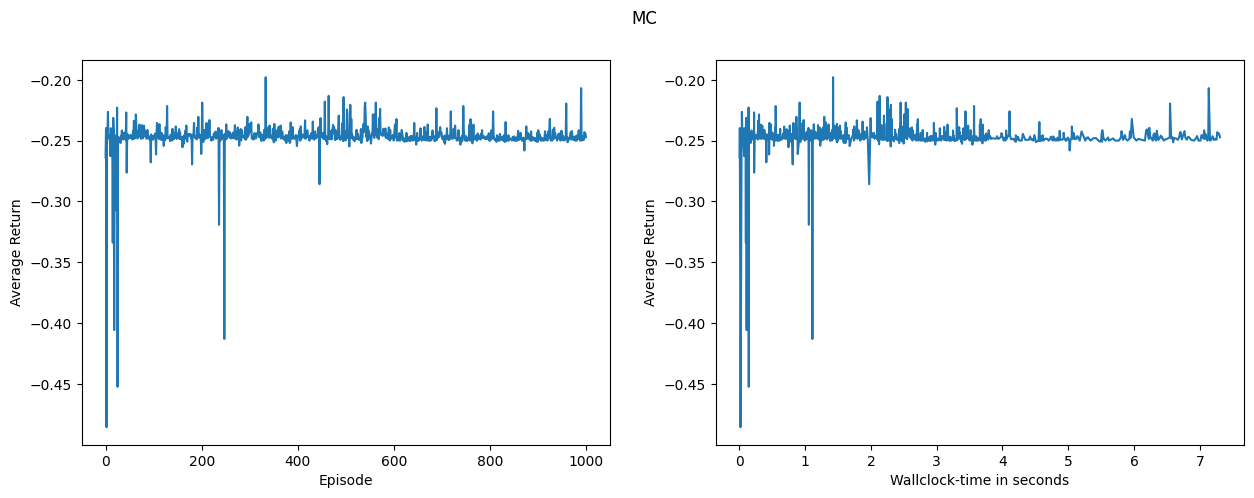

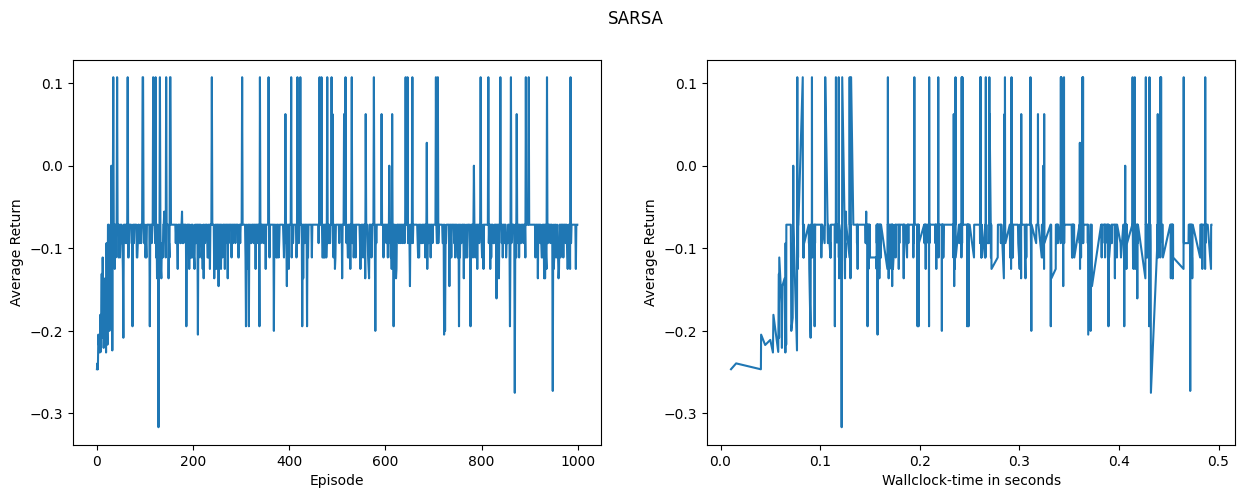

In [ ]:
world = GridWorld(width=4, height=4, start=(0, 0), goal=(3, 3), walls=[(1, 1), (2, 1)], traps=[(3, 1)])
policy = SimpleAgent(world, epsilon = 0.1)
gamma = 0.95
alpha =0.1
num_episodes = 1000

Q_values = init_Q_values(world)

#run MC Control
MC_Q_values, MC_average_returns, MC_episodes_runtime = run_MC_Control(world, policy, Q_values, num_episodes = num_episodes )

#run SARSA
Q_values = init_Q_values(world)
SARSA_Q_values,  SARSA_average_returns, SARSA_episodes_runtime = run_SARSA(world, policy, Q_values, num_episodes = num_episodes)

#plot the average Return-per-Episode and plot it against episodes sampled, and wallclock-time
plot_returns(MC_average_returns, MC_episodes_runtime, num_episodes, "MC")
plot_returns(SARSA_average_returns, SARSA_episodes_runtime, num_episodes, "SARSA")



# 5. Visiualizing Variance-Bias Trade-Off

Pick some average return, which constitures roughly the half-way-point between
your algorithms average starting return and fully trained return. For both MCcontrol (from last weeks homework) and 1-step SARSA, do the following: (pick
the same state for both!)

* For both **SARSA and MC-Control**:
  * Sample 1000 or more episodes starting at some specific (e.g. the
starting) state, with some specific action
  * Update only this specific starting Q-value!
  * Track how the Q-value changes over the episodes (i.e. provide a list
or ndarray with an estimation aver each episode)
* Repeat the above 100 (or more) times for both SARSA and MC-Control
* For both SARSA and MC-Control, create a lineplot including mean and
std estimation (over the 100+ repeats) vs. episodes sampled
* Interprete the result



In [ ]:
def VBT_MC_Control(world, policy, Q_values, specific, gamma = 0.95, num_episodes = 500):
  """
  – Sample 1000 or more episodes starting at some specific (the starting) state, with some specific action
  – Update only this specific starting Q-value!
  – Track how the Q-value changes over the episodes → here: compute mean and std
  => Visualize the Variance-Bias-Tradeoff between MC Control and 1-step SARSA
  
  Args:
      world (GridWorld): The environment in which the agent is acting.
      policy (SimpleAgent): The agent following a certain policy.
      Q_values (dict): The Q-values on which the epsilon-greedy policy is based on.
      specific (tuple): Update only this specific starting Q-value.
      gamma(float): A scaling value for the impact of future rewards. Default is 0.95.
      num_episodes(int): The number of episodes to train the Q-values. Default 500.

  Returns:
      list: the means of the return.
      list: the standard deviation of the return.
  """

  returns = {} #collect the returns G in a dict over all episodes for every Q-value to update the Q-value
  list_Q_values = [] #track the Q-value of the specific state-action pair across the episodes.

  for j in range(num_episodes):

    G = 0
    states, actions, rewards, avg_rewards = run_episode(policy, world, Q_values)

    for i, reward in enumerate(reversed(rewards)):

      G = gamma * G + reward

      if j != 0: #append the total return (G) to the list of Total returns for the specific states
        liste = returns[specific]
        liste.append(G)
        returns[specific] = liste

      else: #initalize a list as the a value in the dict for the specific (s,a)-Pair in the first episode
        returns[specific] = [G]

    Q_values[specific] = np.average(returns[specific])
    list_Q_values.append(Q_values[specific])

  mean = np.mean(list_Q_values) #calculate the mean of the all Q-values of the specific state over all episodes
  std = np.std(list_Q_values) #calculate the standard deviation of the all Q-values of the specific state over all episodes
  
  return mean,std

In [ ]:
def VBT_SARSA(world, policy, Q_values, specific, alpha = 0.1, gamma = 0.95, num_episodes = 500):
  """
  – Sample 1000 or more episodes starting at some specific (the starting) state, with some specific action
  – Update only this specific starting Q-value!
  – Track how the Q-value changes over the episodes → here: compute mean and std
  => Visualize the Variance-Bias-Tradeoff between MC Control and 1-step SARSA
  
  Args:
      world (GridWorld): The environment in which the agent is acting.
      policy (SimpleAgent): The agent following a certain policy.
      Q_values (dict): The Q-values on which the epsilon-greedy policy is based on.
      specific (tuple): Update only this specific starting Q-value.
      alpha (float): The learning rate on which the influence of the Q-Value update is scaled. Default is 0.1.
      gamma(float): A scaling value for the impact of future rewards. Default is 0.95.
      num_episodes(int): The number of episodes to train the Q-values. Default 500.

  Returns:
      list: the means of the return.
      list: the standard deviation of the return.
  """

  list_Q_values = [] #track the Q-value of the specific state-action pair across the episodes.

  for _ in range(num_episodes):

    state = world.start
    action = policy.get_action(Q_values, state)
    next_state = world.transition(state, action)
    next_action = policy.get_action(Q_values, next_state)
    reward = world.reward(next_state)

    steps = 0
    max_steps = 1000

    while state != world.goal and steps < max_steps:
      
      #update only the specific state
      if (state, action) == specific:
        Q_values[(state, action)] += alpha * (reward + gamma * Q_values[(next_state, next_action)] - Q_values[(state, action)])

      state = next_state
      action = policy.get_action(Q_values, state)
      next_state = world.transition(state, action)
      next_action = policy.get_action(Q_values, next_state)
      reward = world.reward(next_state)

      steps += 1

    list_Q_values.append(Q_values[specific])

  mean = np.mean(list_Q_values) #calculate the mean of the all Q-values of the specific state over all episodes
  std = np.std(list_Q_values) #calculate the standard deviation of the all Q-values of the specific state over all episodes

  return mean,std

In [ ]:
def plot_VBT(data):
    """
    Visualize the Variance-Bias tradoff between MC Control and 1-step SARSA.

    Args:
        data(list): tuple list of means and std
    """
    #split data into two separate lists: means and std
    means, std_devs = zip(*data)

    #generate list of episodes
    episodes = list(range(1, len(data) + 1))

    #create the plot
    plt.errorbar(episodes, means, yerr=std_devs, fmt='-o', ecolor='r', capsize=4)

    #add titles and labels
    plt.title("Mean and Standard Deviation per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Mean Value")
    plt.grid(True)

    #display the plot
    plt.show()

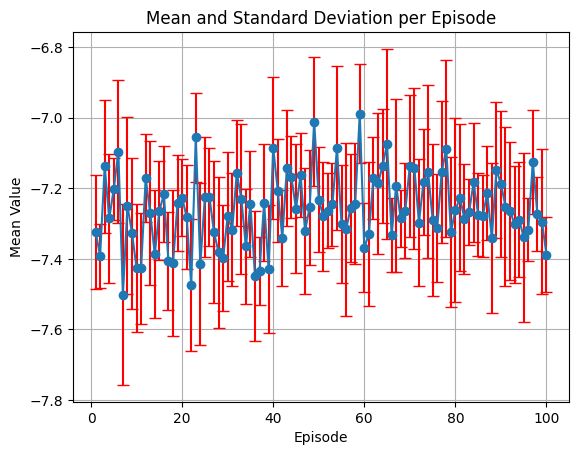

In [ ]:
num_episodes = 1000

#initialize Q_values for all states arbitrarily
Q_values = init_Q_values(world)

mean_std_MC = []
for i in range(100):
  mean_std_MC.append(VBT_MC_Control(world, policy, Q_values, num_episodes = num_episodes, specific = ((0,0),3) ))
  
plot_VBT(mean_std_MC)

100%|██████████| 100/100 [06:12<00:00,  3.72s/it]


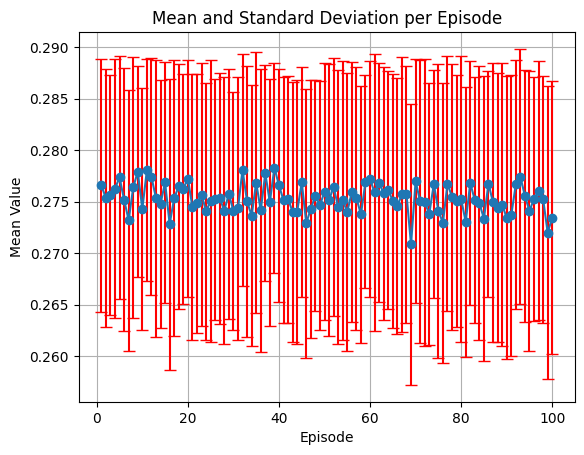

In [ ]:
num_episodes = 1000

Q_values = init_Q_values(world)

mean_std_SARSA = []
for i in tqdm(range(100)):
  mean_std_SARSA.append(VBT_SARSA(world, policy, Q_values, num_episodes = num_episodes, specific = ((0,0),3)))
  
plot_VBT(mean_std_SARSA)